# Standalone generator of an  i.i.d. sequential Gaussian dataset with likelihood ratio.
- Will be stored as LMDB format
- The number of total generated sequence will be BATCH_SIZE * NUM_ITER * NUM_CLASSES

In [7]:
import os, time
import torch
import lmdb
import numpy as np
from tqdm import tqdm
import pickle
from scipy.stats import multivariate_normal
from loguru import logger
import matplotlib.pyplot as plt
from typing import Callable, Tuple, Set, Dict, List


######## USER MODIFIABLE BLOCKS ########
DENSITY_OFFSET = 2.0
BATCH_SIZE = 50
NUM_ITER = 1
NUM_CLASSES = 2
FEAT_DIM = 2

config = {
    'FEAT_DIM' : 2, # 128, # dimension of multivariate Gaussian
    'DENSITY_OFFSET' : DENSITY_OFFSET, # separation of distributions
    'BATCH_SIZE' : BATCH_SIZE, # number of sequence that created at once
    'NUM_ITER' : NUM_ITER, # total data number will be batch_size * num_iter * num_classes
    'TIME_STEPS' : 50, # 50, # length of time steps
    'NUM_CLASSES' : NUM_CLASSES, # class numbers
    'PHASE': 'val',
    'IS_SHUFFLE': True,
    'SAVE_DIR': f'/your/path/to/SequentialGaussian_{NUM_CLASSES}class_offset{DENSITY_OFFSET}_dim{FEAT_DIM}/'
}
######## USER MODIFIABLE BLOCKS END ########



# Util functions

In [8]:
class LMDBDataset(torch.utils.data.Dataset):
    '''
    A PyTorch dataset for reading data and labels from an LMDB database.

    Attributes:
    - lmdb_path (str): The path to the LMDB database.
    - env (lmdb.Environment): The LMDB environment object.
    - data_size (int): The number of data points in the dataset.

    Methods:
    - __len__: Returns the number of data points in the dataset.
    - __getitem__: Returns the data and label for a given index.
    
    '''
    def __init__(self, lmdb_path: str, names: Tuple[str], is_load_onto_memory=True):
        '''
        Required function for PyTorch Dataset class.
        Initializes a new LMDBDataset object.
        
        Args:
        -lmdb_path (str): The path to the LMDB database.
        -names (Tuple[str]): list of to-be-retrieved data. e.g., ('data', 'label')
        
        '''
        super().__init__()
        self.lmdb_path = lmdb_path
        self.names = names
        self.is_load_onto_memory = is_load_onto_memory
        
        # Open a read transaction
        with lmdb.open(lmdb_path, readonly=True) as env:
            with env.begin() as txn:
                # Get the total number of data
                self.data_size = txn.stat()['entries'] // len(names)
                if is_load_onto_memory:
                    self.data = []
                    for i in range(self.data_size):
                        item = {}
                        for name in self.names:
                            item_bytes = txn.get(f'{i:08}_{name}'.encode('ascii'))
                            item[name] = pickle.loads(item_bytes)
                        self.data.append(item)

    def __len__(self) -> int:
        '''
        Required function for PyTorch Dataset class.
        Returns the number of data points in the dataset.
        '''
        return self.data_size
    
    def __getitem__(self, index: int) -> tuple:
        '''
        Required function for PyTorch Dataset class.
        Returns the data and label for a given index.

        Args:
            index: The index of the data point.

        Returns:
            A tuple containing the data and label.
        '''
        
        if self.is_load_onto_memory:
            item = self.data[index]
        else:
            # Open the LMDB database for each worker
            with lmdb.open(self.lmdb_path, readonly=True) as env:
                with env.begin(buffers=True) as txn:
                    item = {}
                    for name in self.names:
                        item_bytes = txn.get(f'{index:08}_{name}'.encode('ascii'))
                        item[name] = pickle.loads(item_bytes)
        # Convert the data and label to PyTorch tensors
        _tensors = []
        for name in self.names:
            if 'label' in name:
                _tensors.append(torch.tensor(item[name]).to(torch.int64))
            else:
                _tensors.append(torch.tensor(item[name]).to(torch.float32))
        
        return tuple(_tensors)


def write_lmdb(txn: lmdb.Transaction, lmdb_path: str, data: Tuple[np.ndarray], 
               names: Tuple[str], offset: int) -> None:
    '''
    Writes the data and labels to an LMDB database.

    Args:
     -txn (lmdb.Environment): An opened LMDB environment object.
    - data (tuple of numpy.ndarray): A tuple of numpy arrays containing the data to be saved.
    - name (tuple of str): A tuple containing the names of the arrays to be saved.
    - offset (int): An integer specifying offset when iterating over a loop.
                    Typically offset is equal to the batch size generated per loop.
                    e.g., offset = i * batch_size
    Returns:
    - None
    '''
    assert len(data) == len(names), 'Number of data and name list must match.'
    
    # Get the number of data points    
    data_number = data[0].shape[0]
    for data_array in data:
        assert data_array.shape[0] == data_number,\
            f'Total {data_array.shape[0]=} and {data_number=} does not match!'

    # Open a write transaction
    for i in tqdm(range(data_number)):
        # Write each data array to the database
        for j, data_array in enumerate(data):
            data_bytes = pickle.dumps(data_array[i])
            name = names[j]
            txn.put('{:08}_{}'.format(i + offset, name).encode('ascii'), data_bytes)
                
                
class ConfigSubset:
    '''
    A class to store the required key-value pairs as instance variables.
    '''
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key.lower(), value)


def extract_params_from_config(requirements: Set[str], config: Dict[str, any]) -> ConfigSubset:
    '''
    Extract necessary (hyper)parameters for each function. The extracted
    parameters are stored as a class instance variables for easy access.
    Keys of the necessary parameters are defined in the set "requirements."
    The keys are converted to lowercase and used for instance variable names.

    Use this class to avoid accidentally overwrite the original config function - 
    remember that python function gets a pointer to the original config dict,
    not a copy of it (i.e., config can be modified within a function).
    
    Args: 
    - requirements (set): required keys for a given function.
    - config (dict): the original dictionary containing all necessary parameters.

    Returns:
    - sub_conf (ConfigSubset): required variables stored as instance variables of a class.
    '''

    # assert that all the required keys exist in the config file.
    missing_keys = requirements.difference(config.keys())
    assert not missing_keys, f"Missing necessary parameters: {', '.join(missing_keys)}"

    sub_conf = ConfigSubset(**{key: config[key] for key in requirements})
    return sub_conf


def initialize_multivariate_gaussian(conf: ConfigSubset) -> Tuple[np.ndarray, np.ndarray, List]:
    '''
    Initialize a multivariate Gaussian distribution for each class.

    Args:
    - conf (ConfigSubset): an instance of the ConfigSubset class containing the following keys:
        - num_classes (int): the number of classes.
        - feat_dim (int): the feature dimension.
        - density_offset (float): the density offset used to initialize the mean vectors.

    Returns:
    - meanvecs (ndarray): an array of shape (num_classes, feat_dim) containing the mean vectors for each class.
    - covmat (ndarray): the covariance matrix, which is a diagonal matrix of shape (feat_dim, feat_dim).
    - pdfs (list): a list of multivariate normal distributions, one for each class.
    '''

    meanvecs = np.zeros((conf.num_classes, conf.feat_dim))
    covmat = np.eye(conf.feat_dim)
    pdfs = []
    for cls_i in range(conf.num_classes):
        meanvecs[cls_i, cls_i] = conf.density_offset
        pdfs.append(multivariate_normal(meanvecs[cls_i], covmat))
    return meanvecs, covmat, pdfs


def compute_log_likelihood_ratio_matrix(x: np.ndarray, pdfs: List, conf: ConfigSubset) -> np.ndarray:
    '''
    Compute the log-likelihood ratio matrix for each sample in x.

    Args:
    - x (ndarray): an array of shape (batch_size, feat_dim) containing the feature vectors.
    - pdfs (list): a list of multivariate normal distributions, one for each class.
    - conf (ConfigSubset): an instance of the ConfigSubset class containing the following keys:
        - num_classes (int): the number of classes.
        - batch_size (int): the number of samples.
        - feat_dim (int): the feature dimension.

    Returns:
    - llrm (ndarray): an array of shape (batch_size, num_classes, num_classes) containing the log-likelihood ratio
      matrix for each sample in x.
    '''

    likelihood = np.zeros((conf.batch_size, conf.num_classes))
    for cls_i in range(conf.num_classes):
        likelihood[:, cls_i] = np.log(pdfs[cls_i].pdf(x))

    llrm = np.zeros((conf.batch_size, conf.num_classes, conf.num_classes))
    for cls_i in range(conf.num_classes):
        for cls_j in range(conf.num_classes):
            # diagonal is zero by definition
            llrm[:, cls_i, cls_j] = likelihood[:, cls_i] - likelihood[:, cls_j]

    return llrm


def plot_likelihood_ratio_matrix(llrm: np.ndarray, gt_labels: np.ndarray, num_trajectories: int = 50) -> None:
    '''
    Plot the likelihood ratio matrix for each pair of classes in llrm.

    Args:
    - llrm (ndarray): an array of shape (batch_size, num_classes, num_classes) containing the log-likelihood ratio
      matrix for each sample in the dataset.
    - gt_labels (ndarray): an array of shape (batch_size) containing the ground truth labels for the samples in the dataset.
    - num_trajectories (int, optional): the number of trajectories to plot for each pair of classes. Defaults to 50.
    '''
    num_classes = llrm.shape[-1]
    colors = plt.cm.tab10(range(num_classes))

    for i in range(num_classes):
        for j in range(num_classes):

            plt.subplot(num_classes, num_classes, (j + 1) + num_classes * i)
            for k, c in zip(range(num_classes), colors):
                plt.plot(np.transpose(llrm[gt_labels==k, :, i, j][:num_trajectories]), color=c)

    # labels
    plt.subplot(num_classes, num_classes, 1)
    for k, c, in zip(range(num_classes), colors):
        plt.plot(np.transpose(llrm[gt_labels==k, :, 0, 0][:1]), color=c, label=f'class {k}')
    plt.legend()
    
    
def iid_multivariate_gaussian(meanvecs: np.ndarray, convmat: np.ndarray, pdfs: List, conf: ConfigSubset) \
                                -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    Generate sequential multivariate Gaussian dataset with likelihood ratio of classes.
    Args:
    - meanvecs (ndarray): an array of shape (num_classes, feat_dim) containing the mean vectors for each class.
    - covmat (ndarray): the covariance matrix of shape (feat_dim, feat_dim).
    - pdfs (list): a list of multivariate normal distributions, one for each class.
    - conf (ConfigSubset): an instance of the ConfigSubset class containing the following keys:
        - num_classes (int): the number of classes.
        - feat_dim (int): the feature dimension.
        - batch_size (int): the number of samples to process at once.
        - time_steps (int): the number of time steps (duration) in the generated dataset.

    Returns:
    - x_iter (ndarray): an array of shape (num_classes * batch_size, time_steps, feat_dim) containing the generated data.
    - y_iter (ndarray): an array of shape (num_classes * batch_size) containing the class labels.
    - llrm_iter (ndarray): an array of shape (num_classes * batch_size, time_steps, num_classes, num_classes)
      containing the likelihood ratio matrix for each sample in the generated data.
    
    '''
    x_cls_pool = []
    y_cls_pool = []
    llrm_cls_pool = []
    for cls_i in range(conf.num_classes):
        y = cls_i * np.ones((conf.batch_size))

        x_time_pool = []
        llrm_time_pool = []
        for t_i in range(conf.time_steps):

            x = np.random.multivariate_normal(meanvecs[cls_i], covmat, conf.batch_size).astype('float32')
            llrm = compute_log_likelihood_ratio_matrix(x, pdfs, conf)

            x_time_pool.append(x)
            llrm_time_pool.append(llrm)

        x_cls = np.stack(x_time_pool, axis=1) # reshape into (BATCH_SIZE, TIME_STEPS, FEAT_DIM)
        llrm_cls = np.stack(llrm_time_pool, axis=1) # reshape into (BATCH_SIZE, TIME_STEPS, NUM_CLASSES, NUM_CLASSES)
        assert x_cls.shape == (conf.batch_size, conf.time_steps, conf.feat_dim)
        assert y.shape == (conf.batch_size,) # size y: (BATCH_SIZE)
        assert llrm_cls.shape == (conf.batch_size, conf.time_steps, conf.num_classes, conf.num_classes)
        x_cls_pool.append(x_cls) 
        y_cls_pool.append(y) 
        llrm_cls_pool.append(llrm_cls) 

    x_iter = np.concatenate(x_cls_pool, axis=0) # reshape into (NUM_CLASSES * BATCH_SIZE, TIME_STEPS, FEAT_DIM)
    y_iter = np.concatenate(y_cls_pool, axis=0) # reshape into (NUM_CLASSES * BATCH_SIZE)
    llrm_iter = np.concatenate(llrm_cls_pool, axis=0) # reshape into (NUM_CLASSES * BATCH_SIZE, TIME_STEPS, NUM_CLASSES, NUM_CLASSES)
    assert x_iter.shape == (conf.num_classes * conf.batch_size, conf.time_steps, conf.feat_dim) 
    assert y_iter.shape == (conf.num_classes * conf.batch_size,)
    assert llrm_iter.shape == (conf.num_classes * conf.batch_size, conf.time_steps, conf.num_classes, conf.num_classes)
    
    # accumulate evidence
    llrm_iter = np.cumsum(llrm_iter, axis=1)
    
    if conf.is_shuffle:
        logger.info('shuffling the data...')
        total_data = conf.num_classes * conf.batch_size
        dice = np.random.permutation(total_data)

        x_iter = x_iter[dice]
        y_iter = y_iter[dice]
        llrm_iter = llrm_iter[dice]
    
    # create a data triplet
    return (x_iter, y_iter, llrm_iter)


class StopWatch:
    '''
    A context manager for measureing the elapsed time of a code block.

    Usage:
        with StopWatch() as time:
            <code block>
        print('elapsed time (sec):', time.elapsed)
    '''
    def __init__(self, unit='hours', label=''):
        '''
        Args:
        - unit (str): specifies time unit \in {seconds, minutes, hours}
        - label (str): added to log message
        '''
        if 'sec' in unit:
            self.denom = 1.
            self.unit = 'seconds'
        elif 'min' in unit:
            self.denom = 60.
            self.unit = 'minutes'
        elif 'hour' in unit:
            self.denom = 3600.
            self.unit = 'hours'
        self.label = label
        
    def __enter__(self):
        
        self.start = time.time()
        
        return self
    
    def __exit__(self, *args):
        self.elapsed = time.time() - self.start
        logger.info(f'elapsed time: {self.elapsed / self.denom} {self.unit}. ({self.label})')



# Generate and save LMDB

In [9]:
# strings to name data names in lmdb
names = ('data', 'label', 'llr')

# The maximum size of the LMDB database in bytes. Default is 1 terabyte.
map_size = int(1e12) 

if not os.path.exists(config['SAVE_DIR']):
    os.makedirs(config['SAVE_DIR'])

config['LMDB_PATH'] = f'{config["SAVE_DIR"]}{config["PHASE"]}_'\
                      f'{config["BATCH_SIZE"] * config["NUM_ITER"] * config["NUM_CLASSES"]}'

# check if necessary parameters are defined in the config file
requirements = set(['FEAT_DIM', 'DENSITY_OFFSET', 'BATCH_SIZE', 'IS_SHUFFLE',
                    'NUM_ITER', 'TIME_STEPS', 'NUM_CLASSES', 'LMDB_PATH'])
conf = extract_params_from_config(requirements, config)

# Open a new LMDB database
with lmdb.open(conf.lmdb_path, map_size=map_size) as env:
    with env.begin(write=True) as txn:
        meanvecs, covmat, pdfs = initialize_multivariate_gaussian(conf)

        for iter_i in range(conf.num_iter):
            logger.info(f'Starting {iter_i=} / {conf.num_iter - 1}')
            data = iid_multivariate_gaussian(meanvecs, covmat, pdfs, conf)
            write_lmdb(txn, conf.lmdb_path, data, names, offset=iter_i * len(data[0]))

logger.info(f'total data genarated:{conf.num_classes * conf.batch_size * conf.num_iter}')
logger.success("done and dusted!")


2023-06-01 09:09:57.894 | INFO     | __main__:<module>:24 - Starting iter_i=0 / 0
2023-06-01 09:09:57.903 | INFO     | __main__:iid_multivariate_gaussian:291 - shuffling the data...
100%|██████████| 100/100 [00:00<00:00, 51787.92it/s]
2023-06-01 09:09:57.914 | INFO     | __main__:<module>:28 - total data genarated:100
2023-06-01 09:09:57.915 | SUCCESS  | __main__:<module>:29 - done and dusted!


# Load LMDB: sanity check

In [10]:
# you need 'names' to load data correctly
dataset = LMDBDataset(conf.lmdb_path, names=names)

# pin_memory for performance
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1000, pin_memory=True, num_workers=0, shuffle=True)


In [11]:
# load one example batch
with StopWatch(unit='sec'):
    for i, data in enumerate(dataloader):
        x, y, llr = data
print(i + 1)


2023-04-07 07:36:20.877 | INFO     | __main__:__exit__:337 - elapsed time: 0.8577005863189697 seconds. ()


30


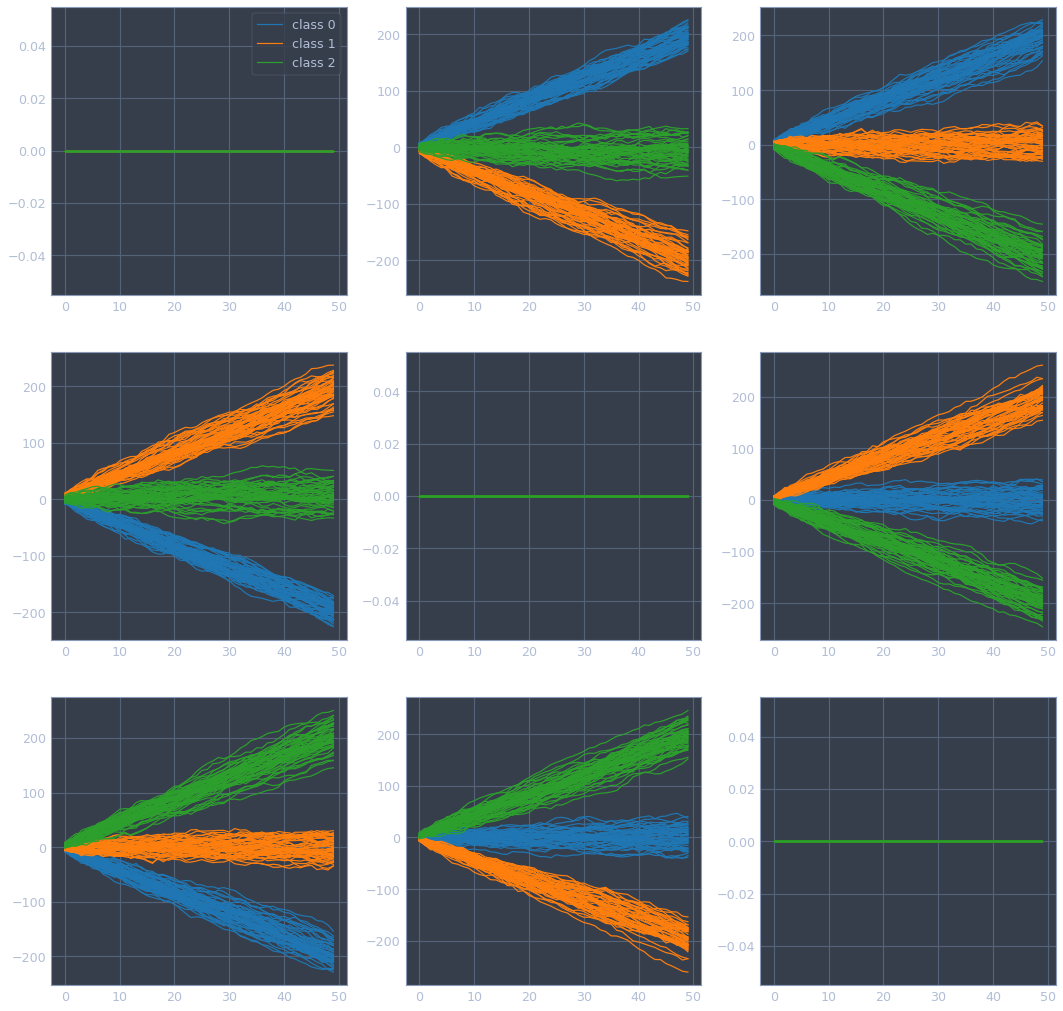

In [12]:
plt.figure(figsize=(18, 18))
plot_likelihood_ratio_matrix(llr, y)